# Calculate Correlations Between SMYLE and Obs (or FOSI reconstruction)

Sam Mogen

In [80]:
%load_ext autoreload
%autoreload 2
import xarray as xr 
import numpy as np  
import cftime
import copy
import scipy.stats
from scipy import signal
from functools import partial
import glob
import dask
import matplotlib.pyplot as plt
%matplotlib inline

import esmtools as esmtools
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [81]:
#!pip install geopandas
import geopandas as gp

In [82]:
# !pip install regionmask
import regionmask

In [83]:
# SMYLE Utility functions
from SMYLEutils import io_utils as io
from SMYLEutils import calendar_utils as cal
from SMYLEutils import stat_utils as stat

In [84]:
import pandas as pd

## Load in regridded SMYLE data

In [66]:
var = 'omega_arag'

In [68]:
omega02 = xr.open_dataset(var+'.02.regrid.nc')
omega02_time = xr.open_dataset('omega_arag.02.time.nc')

omega05 = xr.open_dataset(var+'.05.regrid.nc')
omega05_time = xr.open_dataset('omega_arag.05.time.nc')

omega08 = xr.open_dataset(var+'.08.regrid.nc')
omega08_time = xr.open_dataset('omega_arag.08.time.nc')

omega11 = xr.open_dataset(var+'.11.regrid.nc')
omega11_time = xr.open_dataset('omega_arag.11.time.nc')

In [16]:
# __xarray_dataarray_variable__
var = 'omega_arag'

omega02 = omega02[var]
omega05 = omega05[var]
omega08 = omega08[var]
omega11 = omega11[var]

## Load in regridded observational and cesm-le data

In [17]:
var = 'omega'

In [18]:
ice = xr.open_dataset('/glade/work/smogen/SMYLE-personal/SMYLE-FOSI/ECOSYS_IFRAC.regrid.nc')
ice = ice.mean(dim='time')

In [19]:
obs = xr.open_dataset('/glade/work/smogen/SMYLE-personal/OceanSODA-ETHZ_1985-2019_v2020b.regrid2.nc')

In [17]:
var = 'omega'

In [29]:
def obs_convert_mon_to_seas(da,field):
    """ Given a monthly xarray DataArray, convert to 
    seasonal averages and introduce a separate season dimension."""
    season = xr.DataArray(['DJF','MAM','JJA','SON'],dims='season',name='season')
    da_group = cal.mon_to_seas(da).groupby('time.month')
    xrlist = []
    for i in [1,4,7,10]:
        tmp = da_group[i]
        tmp = tmp.assign_coords(year=("time", np.unique(tmp.time.dt.year.values)))
        tmp = tmp.swap_dims({"time": "year"})#.to_dataset(name=field)
        tmp = tmp.reset_coords(["time"])
        tmp["time"] = tmp.time.expand_dims("season")
        xrlist.append(tmp)
    da_seas = xr.concat(xrlist,dim=season)
    return da_seas

In [30]:
def obs_convert_mon_to_seas_persist(da,field):
    """ Given a monthly xarray DataArray, convert to 
    seasonal averages and introduce a separate season dimension."""
    season = xr.DataArray(['FMA','MJJ','ASO','NDJ'],dims='season',name='season')
    month_length = obs.time.dt.days_in_month
    result = ((obs * month_length).resample(time='3M',loffset='45D').sum() / month_length.resample(time='3M',loffset='45D').sum())
    
    da_group = result.groupby('time.month')
    xrlist = []
    for i in [3,6,9,12]:
        tmp = da_group[i]
        tmp = tmp.assign_coords(year=("time", np.unique(tmp.time.dt.year.values)))
        tmp = tmp.swap_dims({"time": "year"})#.to_dataset(name=field)
        tmp = tmp.reset_coords(["time"])
        tmp["time"] = tmp.time.expand_dims("season")
        xrlist.append(tmp)
    da_seas = xr.concat(xrlist,dim=season)
    return da_seas

## convert obs and LE to a seasonal timescale

In [31]:
var = 'omegaAR'

In [32]:
# obs = obs.rename({'temperature':'TEMP'})
obs_seas = obs_convert_mon_to_seas(obs,var)#.sel(year=slice("1960","2019"))

In [33]:
obs_seas_persist = obs_convert_mon_to_seas_persist(obs,var)#.sel(year=slice("1960","2019"))

In [34]:
uninit_seas = obs_convert_mon_to_seas(uninit,var)#.sel(year=slice("1960","2019"))

In [35]:
fosi_seas = obs_convert_mon_to_seas(fosi,var)#.sel(year=slice("1960","2019"))
dple_fosi_seas = obs_convert_mon_to_seas(dple_fosi,var)

In [36]:
# create anomaly!
obs_seas = obs_seas - obs_seas.mean('year')
obs_seas_persist = obs_seas_persist - obs_seas_persist.mean('year')
uninit_seas = uninit_seas - uninit_seas.mean('year')
fosi_seas = fosi_seas - fosi_seas.mean('year')
dple_fosi_seas = dple_fosi_seas - dple_fosi_seas.mean('year')

## Create area masks

In [37]:
weights = np.cos(np.deg2rad(obs_seas.lat))
weights.name = "weights"

In [38]:
# CalCS
lmes = gp.read_file("/glade/work/smogen/SMYLE-personal/LME66")
reg = lmes[lmes.LME_NAME == 'California Current']
lon = fosi_seas.lon
lat = fosi_seas.lat
mask = regionmask.mask_geopandas(reg, lon, lat)

In [39]:
# Nino3.4
lat_nino = slice(-5,5)
lon_nino = slice(190,240)

In [40]:
# North Atlantic
lat_natl = slice(55,60)
lon_natl = slice(310,330)

In [41]:
ice = xr.open_dataset('/glade/work/smogen/SMYLE-personal/SMYLE-FOSI/ECOSYS_IFRAC.regrid.nc')
ice = ice.mean(dim='time')

## Remove Drift

In [43]:
# Compute de-drifted anomalies from 1972-2017 climatology
smyle11_anom,smyle11_clim = stat.remove_drift(omega11,omega11_time,1972,2017)
smyle02_anom,smyle02_clim = stat.remove_drift(omega02,omega02_time,1972,2017)
smyle05_anom,smyle05_clim = stat.remove_drift(omega05,omega05_time,1972,2017)
smyle08_anom,smyle08_clim = stat.remove_drift(omega08,omega08_time,1972,2017)

In [44]:
omega02 = smyle02_anom.time
omega05 = smyle05_anom.time
omega08 = smyle08_anom.time
omega11 = smyle11_anom.time

In [74]:
# Skill Score Functions
import xskillscore as xs
import esmtools as stat2

def detrend_linear(dat, dim):
    """ linear detrend dat along the axis dim """
    params = dat.polyfit(dim=dim, deg=1)
    fit = xr.polyval(dat[dim], params.polyfit_coefficients)
    dat = dat-fit
    return dat

# def leadtime_corr_byseas(mod_da,mod_time,obs_skill,ref_dple,obs_persist,_da,season,detrend=False):
def leadtime_corr_byseas(mod_da,mod_time,obs_skill,obs_persist,init,detrend=False):
    """ 
    Computes the correlation coefficient between two xarray DataArrays, which 
    must share the same lat/lon coordinates (if any). Assumes time coordinates are roughly compatible
    between model and obs.
    
        Inputs
        mod_da: a seasonally-averaged hindcast DataArray dimensioned (Y,L,M,...)
        mod_time: a hindcast time DataArray dimensioned (Y,L). NOTE: assumes mod_time.dt.month
            returns mid-month of 3-month seasonal average (e.g., mon=1 ==> "DJF").
        obs_da: an OBS DataArray dimensioned (time,...) on seasonal timescales
        obs_persist: an OBS DataArray dimensioned (time,...) used for the persistence forecast 
        season
    """
    obs_da = obs_skill
    
    ens = mod_da.mean('M')
    seasons = {1:'DJF',4:'MAM',7:'JJA',10:'SON'}
    r_list = []
    r2_list = []
    p_list = []
    a_list = []
    
    # align the persistence forecast observations with the ensemble
    obs_persist = obs_persist
    obs_persist['season'] = obs_da['season']
    
    # try to do autocorrelation:
    if init == '02':
        j = 3
    elif init == '05':
        j = 0
    elif init == '08':
        j = 1
    elif init == '11':
        j = 2

    obs_persist = obs_calcs_persist

    obs_persist = obs_persist.isel(season = j)
    obs_persist = detrend_linear(obs_persist, 'year')
    aut_persist = stat2.stats.autocorr(obs_persist.dropna('year'),nlags=9,dim='year') # autocorrelation
    aut_persist = aut_persist.isel(lead=slice(1,9))
    aut_persist = aut_persist.rename({'lead':'L'})

    #### skill calculations
    for i in ens.L.values:
        ens_ts = ens.sel(L=i).rename({'Y':'time'})
        ens_time_year = mod_time.sel(L=i).dt.year.data
        ens_time_month = mod_time.sel(L=i).dt.month.data[0]
        
        obs_ts = obs_da.sel(season=seasons[ens_time_month]).rename({'year':'time'})
        ens_ts = ens_ts.assign_coords(time=("time",ens_time_year))
        
        a,b = xr.align(ens_ts,obs_ts)
        
        if detrend:
                a = detrend_linear(a,'time')
                b = detrend_linear(b,'time')
                d = detrend_linear(d,'time')
                # persist = detrend_linear(persist,'time')
                
        r = xr.corr(a,b) # initialized skill
        # r2 = xr.corr(b,d) # uninitialized skill

        p = xs.pearson_r_eff_p_value(a,b,dim='time',skipna=True) # significance testing
                
        r_list.append(r)
        p_list.append(p)
    corr = xr.concat(r_list,ens.L)
    corr2 = xr.concat(r2_list,ens.L)
    pval = xr.concat(p_list,ens.L)
    
    aut_persist['season'] = corr.season

    return xr.Dataset({'corr':corr,'pval':pval,'auto_val':aut_persist})

## Mask out Smyle and Obs

In [46]:
var = 'omegaAR'

In [51]:
# CalCS
obs_calcs = obs_seas[var].where(mask==9).weighted(weights).mean(dim=('lat','lon'))
obs_calcs_persist = obs_seas_persist[var].where(mask==9).weighted(weights).mean(dim=('lat','lon'))

# var = 'SST'
uninit_calcs = uninit_seas[var].where(mask==9).weighted(weights).mean(dim=('lat','lon'))

fosi_calcs = fosi_seas[var].where(mask==9).weighted(weights).mean(dim=('lat','lon'))

smyle02_calcs = omega02.where(mask==9).weighted(weights).mean(dim=('lat','lon'))
smyle05_calcs = omega05.where(mask==9).weighted(weights).mean(dim=('lat','lon'))
smyle08_calcs = omega08.where(mask==9).weighted(weights).mean(dim=('lat','lon'))
smyle11_calcs = omega11.where(mask==9).weighted(weights).mean(dim=('lat','lon'))

# dple11_calcs = dple11.where(mask==9).weighted(weights).mean(dim=('lat','lon'))

In [52]:
# Nino3.4
obs_nino = obs_seas[var].sel(lon = lon_nino, lat = lat_nino).weighted(weights).mean(dim=('lat','lon'))
obs_nino_persist = obs_seas_persist[var].sel(lon = lon_nino, lat = lat_nino).weighted(weights).mean(dim=('lat','lon'))

# var = 'SST'
uninit_nino = uninit_seas[var].sel(lon = lon_nino, lat = lat_nino).weighted(weights).mean(dim=('lat','lon'))
# var = 'TEMP'

fosi_nino = fosi_seas[var].sel(lon = lon_nino, lat = lat_nino).weighted(weights).mean(dim=('lat','lon'))

smyle02_nino = omega02.sel(lon = lon_nino, lat = lat_nino).weighted(weights).mean(dim=('lat','lon'))
smyle05_nino = omega05.sel(lon = lon_nino, lat = lat_nino).weighted(weights).mean(dim=('lat','lon'))
smyle08_nino = omega08.sel(lon = lon_nino, lat = lat_nino).weighted(weights).mean(dim=('lat','lon'))
smyle11_nino = omega11.sel(lon = lon_nino, lat = lat_nino).weighted(weights).mean(dim=('lat','lon'))

In [54]:
# N. Atlantic
obs_natl = obs_seas[var].sel(lon = lon_natl, lat = lat_natl).weighted(weights).mean(dim=('lat','lon'))
obs_natl_persist = obs_seas_persist[var].sel(lon = lon_natl, lat = lat_natl).weighted(weights).mean(dim=('lat','lon'))

# var = 'SST'
uninit_natl = uninit_seas[var].sel(lon = lon_natl, lat = lat_natl).weighted(weights).mean(dim=('lat','lon'))
# var = 'TEMP'

fosi_natl = fosi_seas[var].sel(lon = lon_natl, lat = lat_natl).weighted(weights).mean(dim=('lat','lon'))

smyle02_natl = omega02.sel(lon = lon_natl, lat = lat_natl).weighted(weights).mean(dim=('lat','lon'))
smyle05_natl = omega05.sel(lon = lon_natl, lat = lat_natl).weighted(weights).mean(dim=('lat','lon'))
smyle08_natl = omega08.sel(lon = lon_natl, lat = lat_natl).weighted(weights).mean(dim=('lat','lon'))
smyle11_natl = omega11.sel(lon = lon_natl, lat = lat_natl).weighted(weights).mean(dim=('lat','lon'))

In [56]:
# Global
obs_glob = obs_seas[var].where(ice.ECOSYS_IFRAC == 0, np.NaN).weighted(weights).mean(dim=('lat','lon'))
obs_glob_persist = obs_seas_persist[var].where(ice.ECOSYS_IFRAC == 0, np.NaN).weighted(weights).mean(dim=('lat','lon'))

# var = 'SST'
uninit_glob = uninit_seas[var].where(ice.ECOSYS_IFRAC == 0, np.NaN).weighted(weights).mean(dim=('lat','lon'))
# var = 'TEMP'

fosi_glob = fosi_seas[var].where(ice.ECOSYS_IFRAC == 0, np.NaN).weighted(weights).mean(dim=('lat','lon'))

smyle02_glob = omega02.where(ice.ECOSYS_IFRAC == 0, np.NaN).weighted(weights).mean(dim=('lat','lon'))
smyle05_glob = omega05.where(ice.ECOSYS_IFRAC == 0, np.NaN).weighted(weights).mean(dim=('lat','lon'))
smyle08_glob = omega08.where(ice.ECOSYS_IFRAC == 0, np.NaN).weighted(weights).mean(dim=('lat','lon'))
smyle11_glob = omega11.where(ice.ECOSYS_IFRAC == 0, np.NaN).weighted(weights).mean(dim=('lat','lon'))

## Calculate ACC for all regions

In [85]:
%%time
smyle11_corr_calcs = leadtime_corr_byseas(smyle11_calcs,omega11_time.time,obs_calcs,obs_calcs_persist,'11',detrend=True)
smyle02_corr_calcs = leadtime_corr_byseas(smyle02_calcs,omega02_time.time,obs_calcs,obs_calcs_persist,'02',detrend=True)
smyle05_corr_calcs = leadtime_corr_byseas(smyle05_calcs,omega05_time.time,obs_calcs,obs_calcs_persist,'05',detrend=True)
smyle08_corr_calcs = leadtime_corr_byseas(smyle08_calcs,omega08_time.time,obs_calcs,,obs_calcs_persist,,'08',detrend=True)

CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 µs
Wall time: 4.53 µs


In [203]:
%%time
smyle02_corr_nino = leadtime_corr_byseas(smyle02_nino,omega02_time.time,obs_nino,obs_nino_persist,'02',detrend=True)
smyle05_corr_nino = leadtime_corr_byseas(smyle05_nino,omega05_time.time,obs_nino,obs_nino_persist,'05',detrend=True)
smyle08_corr_nino = leadtime_corr_byseas(smyle08_nino,omega08_time.time,obs_nino,obs_nino_persist,'08',detrend=True)
smyle11_corr_nino = leadtime_corr_byseas(smyle11_nino,omega11_time.time,obs_nino,obs_nino_persist,'11',detrend=True)

CPU times: user 1.15 s, sys: 11.9 ms, total: 1.16 s
Wall time: 1.2 s


In [204]:
%%time
smyle02_corr_natl = leadtime_corr_byseas(smyle02_natl,omega02_time.time,obs_natl,obs_natl_persist,'02',detrend=True)
smyle05_corr_natl = leadtime_corr_byseas(smyle05_natl,omega05_time.time,obs_natl,obs_natl_persist,'05',detrend=True)
smyle08_corr_natl = leadtime_corr_byseas(smyle08_natl,omega08_time.time,obs_natl,obs_natl_persist,'08',detrend=True)
smyle11_corr_natl = leadtime_corr_byseas(smyle11_natl,omega11_time.time,obs_natl,obs_natl_persist,'11',detrend=True)

CPU times: user 1.15 s, sys: 9.2 ms, total: 1.16 s
Wall time: 1.18 s


In [205]:
%%time
smyle02_corr_glob = leadtime_corr_byseas(smyle02_glob,omega02_time.time,obs_glob,obs_glob_persist,'02',detrend=True)
smyle05_corr_glob = leadtime_corr_byseas(smyle05_glob,omega05_time.time,obs_glob,obs_glob_persist,'05',detrend=True)
smyle08_corr_glob = leadtime_corr_byseas(smyle08_glob,omega08_time.time,obs_glob,obs_glob_persist,'08',detrend=True)
smyle11_corr_glob = leadtime_corr_byseas(smyle11_glob,omega11_time.time,obs_glob,obs_glob_persist,'11',detrend=True)

CPU times: user 1.14 s, sys: 7.92 ms, total: 1.15 s
Wall time: 1.17 s


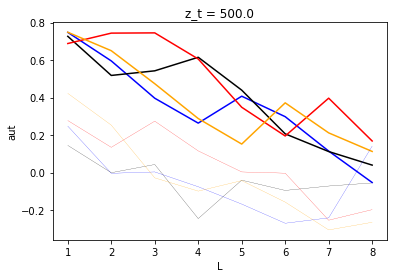

In [180]:
smyle11_corr_calcs.corr.plot(color='blue')
smyle02_corr_calcs.corr.plot(color='k')
smyle05_corr_calcs.corr.plot(color='red')
smyle08_corr_calcs.corr.plot(color='orange')

smyle11_corr_calcs.aut.plot(color='blue',linewidth=0.2)
smyle02_corr_calcs.aut.plot(color='k',linewidth=0.2)
smyle05_corr_calcs.aut.plot(color='red',linewidth=0.2)
smyle08_corr_calcs.aut.plot(color='orange',linewidth=0.2)

# dple11_corr_glob.corr.plot(color='orange',linewidth=2)

In [181]:
var

'omegaAR'

In [54]:
smyle02_corr_calcs.to_netcdf('/glade/work/smogen/SMYLE-personal/SMYLE-Data/predictability_ts/smyle02.'+var+'.calcs.predictability.nc',mode='w')
smyle05_corr_calcs.to_netcdf('/glade/work/smogen/SMYLE-personal/SMYLE-Data/predictability_ts/smyle05.'+var+'.calcs.predictability.nc',mode='w')
smyle08_corr_calcs.to_netcdf('/glade/work/smogen/SMYLE-personal/SMYLE-Data/predictability_ts/smyle08.'+var+'.calcs.predictability.nc',mode='w')
smyle11_corr_calcs.to_netcdf('/glade/work/smogen/SMYLE-personal/SMYLE-Data/predictability_ts/smyle11.'+var+'.calcs.predictability.nc',mode='w')
dple11_corr_calcs.to_netcdf('/glade/work/smogen/SMYLE-personal/SMYLE-Data/predictability_ts/dple11.'+var+'.calcs.predictability.nc',mode='w')

smyle02_corr_natl.to_netcdf('/glade/work/smogen/SMYLE-personal/SMYLE-Data/predictability_ts/smyle02.'+var+'.natl.predictability.nc',mode='w')
smyle05_corr_natl.to_netcdf('/glade/work/smogen/SMYLE-personal/SMYLE-Data/predictability_ts/smyle05.'+var+'.natl.predictability.nc',mode='w')
smyle08_corr_natl.to_netcdf('/glade/work/smogen/SMYLE-personal/SMYLE-Data/predictability_ts/smyle08.'+var+'.natl.predictability.nc',mode='w')
smyle11_corr_natl.to_netcdf('/glade/work/smogen/SMYLE-personal/SMYLE-Data/predictability_ts/smyle11.'+var+'.natl.predictability.nc',mode='w')
dple11_corr_natl.to_netcdf('/glade/work/smogen/SMYLE-personal/SMYLE-Data/predictability_ts/dple11.'+var+'.natl.predictability.nc',mode='w')

smyle02_corr_nino.to_netcdf('/glade/work/smogen/SMYLE-personal/SMYLE-Data/predictability_ts/smyle02.'+var+'.nino.predictability.nc',mode='w')
smyle05_corr_nino.to_netcdf('/glade/work/smogen/SMYLE-personal/SMYLE-Data/predictability_ts/smyle05.'+var+'.nino.predictability.nc',mode='w')
smyle08_corr_nino.to_netcdf('/glade/work/smogen/SMYLE-personal/SMYLE-Data/predictability_ts/smyle08.'+var+'.nino.predictability.nc',mode='w')
smyle11_corr_nino.to_netcdf('/glade/work/smogen/SMYLE-personal/SMYLE-Data/predictability_ts/smyle11.'+var+'.nino.predictability.nc',mode='w')
dple11_corr_nino.to_netcdf('/glade/work/smogen/SMYLE-personal/SMYLE-Data/predictability_ts/dple11.'+var+'.nino.predictability.nc',mode='w')

smyle02_corr_glob.to_netcdf('/glade/work/smogen/SMYLE-personal/SMYLE-Data/predictability_ts/smyle02.'+var+'.glob.predictability.nc',mode='w')
smyle05_corr_glob.to_netcdf('/glade/work/smogen/SMYLE-personal/SMYLE-Data/predictability_ts/smyle05.'+var+'.glob.predictability.nc',mode='w')
smyle08_corr_glob.to_netcdf('/glade/work/smogen/SMYLE-personal/SMYLE-Data/predictability_ts/smyle08.'+var+'.glob.predictability.nc',mode='w')
smyle11_corr_glob.to_netcdf('/glade/work/smogen/SMYLE-personal/SMYLE-Data/predictability_ts/smyle11.'+var+'.glob.predictability.nc',mode='w')
dple11_corr_glob.to_netcdf('/glade/work/smogen/SMYLE-personal/SMYLE-Data/predictability_ts/dple11.'+var+'.glob.predictability.nc',mode='w')

In [1]:
var = 'omega'

In [21]:
tmp = xr.open_dataset('/glade/work/smogen/SMYLE-personal/SMYLE-Data/timeseries/smyle02.'+var+'.calcs.nc')
# smyle05_corr_calcs = xr.open_dataset('/glade/work/smogen/SMYLE-personal/SMYLE-Data/timeseries/smyle05.'+var+'.calcs.nc')
# smyle08_corr_calcs = xr.open_dataset('/glade/work/smogen/SMYLE-personal/SMYLE-Data/timeseries/smyle08.'+var+'.calcs.nc',mode='w')
# smyle11_corr_calcs = xr.open_dataset('/glade/work/smogen/SMYLE-personal/SMYLE-Data/timeseries/smyle11.'+var+'.calcs.nc',mode='w')
# # dple11_corr_calcs = xr.open_dataset('/glade/work/smogen/SMYLE-personal/SMYLE-Data/timeseries/dple11.'+var+'.calcs.predictability.nc',mode='w')

# smyle02_corr_natl = xr.open_dataset('/glade/work/smogen/SMYLE-personal/SMYLE-Data/timeseries/smyle02.'+var+'.natl.nc',mode='w')
# smyle05_corr_natl = xr.open_dataset('/glade/work/smogen/SMYLE-personal/SMYLE-Data/timeseries/smyle05.'+var+'.natl.nc',mode='w')
# smyle08_corr_natl = xr.open_dataset('/glade/work/smogen/SMYLE-personal/SMYLE-Data/timeseries/smyle08.'+var+'.natl.nc',mode='w')
# smyle11_corr_natl = xr.open_dataset('/glade/work/smogen/SMYLE-personal/SMYLE-Data/timeseries/smyle11.'+var+'.natl.nc',mode='w')
# # dple11_corr_natl = xr.open_dataset('/glade/work/smogen/SMYLE-personal/SMYLE-Data/timeseries/dple11.'+var+'.natl.predictability.nc',mode='w')

# smyle02_corr_nino = xr.open_dataset('/glade/work/smogen/SMYLE-personal/SMYLE-Data/timeseries/smyle02.'+var+'.nino.nc',mode='w')
# smyle05_corr_nino = xr.open_dataset('/glade/work/smogen/SMYLE-personal/SMYLE-Data/timeseries/smyle05.'+var+'.nino.nc',mode='w')
# smyle08_corr_nino = xr.open_dataset('/glade/work/smogen/SMYLE-personal/SMYLE-Data/timeseries/smyle08.'+var+'.nino.nc',mode='w')
# smyle11_corr_nino = xr.open_dataset('/glade/work/smogen/SMYLE-personal/SMYLE-Data/timeseries/smyle11.'+var+'.nino.nc',mode='w')
# # dple11_corr_nino.to_netcdf('/glade/work/smogen/SMYLE-personal/SMYLE-Data/timeseries/dple11.'+var+'.nino.predictability.nc',mode='w')

# smyle02_corr_glob = xr.open_dataset('/glade/work/smogen/SMYLE-personal/SMYLE-Data/timeseries/smyle02.'+var+'.glob.nc',mode='w')
# smyle05_corr_glob = xr.open_dataset('/glade/work/smogen/SMYLE-personal/SMYLE-Data/timeseries/smyle05.'+var+'.glob.nc',mode='w')
# smyle08_corr_glob = xr.open_dataset('/glade/work/smogen/SMYLE-personal/SMYLE-Data/timeseries/smyle08.'+var+'.glob.nc',mode='w')
# smyle11_corr_glob = xr.open_dataset('/glade/work/smogen/SMYLE-personal/SMYLE-Data/timeseries/smyle11.'+var+'.glob.nc',mode='w')
# # dple11_corr_glob.to_netcdf('/glade/work/smogen/SMYLE-personal/SMYLE-Data/timeseries/dple11.'+var+'.glob.predictability.nc',mode='w')

In [20]:
smyle05_corr_calcs

<xarray.Dataset>
Dimensions:  ()
Data variables:
    *empty*

## combine all the data

In [206]:
#calcs
smyle11_skill_reg1 = smyle11_corr_calcs
smyle02_skill_reg1 = smyle02_corr_calcs
smyle05_skill_reg1 = smyle05_corr_calcs
smyle08_skill_reg1 = smyle08_corr_calcs

#nino3.4
smyle11_skill_reg2 = smyle11_corr_nino
smyle02_skill_reg2 = smyle02_corr_nino
smyle05_skill_reg2 = smyle05_corr_nino
smyle08_skill_reg2 = smyle08_corr_nino

#natl
smyle11_skill_reg3 = smyle11_corr_natl
smyle02_skill_reg3 = smyle02_corr_natl
smyle05_skill_reg3 = smyle05_corr_natl
smyle08_skill_reg3 = smyle08_corr_natl

region1title = 'CalCS'
region2title = 'Nino3.4'
region3title = 'North Atlantic'

In [207]:
# combine skill score xarrays for plotting
startmonth= xr.DataArray([11,2,5,8],name='startmonth',dims='startmonth')
region = xr.DataArray([1,2,3],name='region',dims='region')
reg1_skill = xr.concat([smyle11_skill_reg1,smyle02_skill_reg1,smyle05_skill_reg1,smyle08_skill_reg1],dim=startmonth)
reg2_skill = xr.concat([smyle11_skill_reg2,smyle02_skill_reg2,smyle05_skill_reg2,smyle08_skill_reg2],dim=startmonth)
reg3_skill = xr.concat([smyle11_skill_reg3,smyle02_skill_reg3,smyle05_skill_reg3,smyle08_skill_reg3],dim=startmonth)
reg_skill = xr.concat([reg1_skill,reg2_skill,reg3_skill],dim=region)
regiontitle = xr.DataArray([region1title,region2title,region3title],name='regiontitle',dims='region')
reg_skill['regiontitle'] = regiontitle


In [208]:
reg1_skill.to_netcdf('/glade/work/smogen/SMYLE-personal/steve.reg1.calcs.nc')
reg2_skill.to_netcdf('/glade/work/smogen/SMYLE-personal/steve.reg2.nino.nc')
reg3_skill.to_netcdf('/glade/work/smogen/SMYLE-personal/steve.reg3.natl.nc')

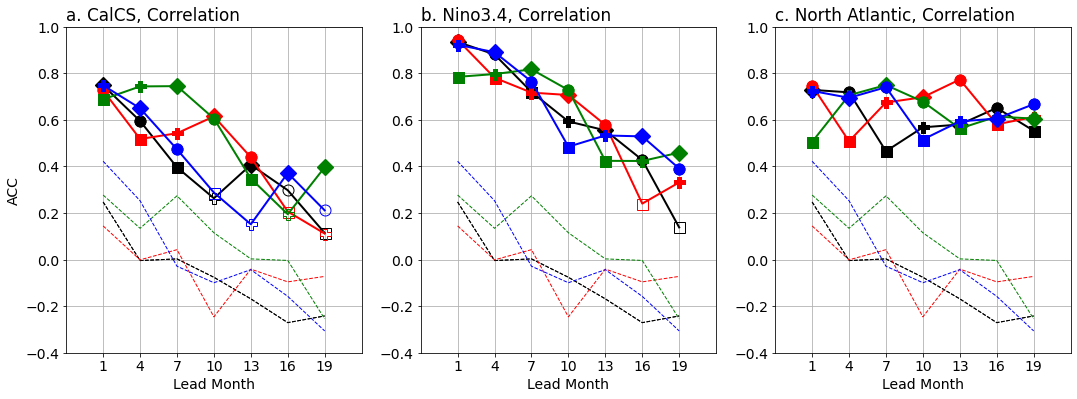

In [211]:
# plot skill scores
fig = plt.figure(figsize=(18,6))
plt.rcParams['font.size'] = '14'
leadmon = smyle11_skill_reg1.L[0:7]
# seasons = ['DJF','MAM','JJA','SON']
seasons = ['DJF','MAM','JJA','SON',]

markers = ['D','o','s','P']
colors = ['k','r','g','b']

hindcasts = ['NOV','FEB','MAY','AUG']
figlabs = [['a.','b.','c.'],['d.','e.','f.']]

ncol = 3
nrow = 1

for i in range(ncol):
    ax = fig.add_subplot(nrow,ncol,i+1)
    ax.plot(leadmon,reg_skill.isel(L=slice(0,7)).isel(region=0,startmonth=0).auto_val,'--',color='k',linewidth=1,label='Persistence')
    if i==0: ax.set_ylabel('ACC', fontsize=14)
    ax.set_title(figlabs[0][i]+' {}, Correlation'.format(reg_skill.isel(region=i).regiontitle.values),loc='left')
    for j in range(4):
        ax.plot(leadmon,reg_skill.isel(L=slice(0,7)).isel(region=i,startmonth=j).corr,color=colors[j],linewidth=2,label='SMYLE-'+hindcasts[j])
        for k,l in zip(seasons,markers):
            tmp = reg_skill.isel(L=slice(0,7)).isel(region=i,startmonth=j)
            ax.plot(leadmon,tmp.corr.where(tmp.season==k),color=colors[j],marker=l,markersize=11,fillstyle='none')
            ax.plot(leadmon,tmp.corr.where(tmp.season==k).where(tmp.pval<0.1),color=colors[j],marker=l,markersize=11)
        
#         ax.plot(leadmon,reg_skill.isel(region=0,startmonth=0).auto_val,'--',color='k',linewidth=0.5,label='Persistence')
        ax.plot(leadmon,reg_skill.isel(L=slice(0,7)).isel(region=i,startmonth=j).auto_val,'--',color=colors[j],linewidth=1)
        
    # if i==2: leg1 = ax.legend(loc='lower left',ncol=1)
    ax.set_xticks(leadmon)
    ax.grid(True)
    ax.set_xlim([0,20])
    ax.set_ylim([-0.4,1])
        
    ax.set_xticks(ticks=leadmon)
    # ax.set_xticklabels(labels=['1','4','7','10','13','16','19','22'])
    ax.set_xticklabels(labels=['1','4','7','10','13','16','19'])
    ax.set_xlabel('Lead Month')
    ax.grid(True)
    ax.set_xlim([0,8])
    ax.set_ylim([-0.4,1])
    
plt.savefig('SMYLE_seasonalSSTindices_skill.pdf')